# 40 kHz Scans

40 kHz sound signal from piezo was recorded using microphone and Sagnac. This data allows us to see 

In [10]:
from analysis import System

sagnac_40kHz = System("sagnac", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 1e6)
mic_40kHz = System("mic", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)], SNR_freq_cut = 2e5)

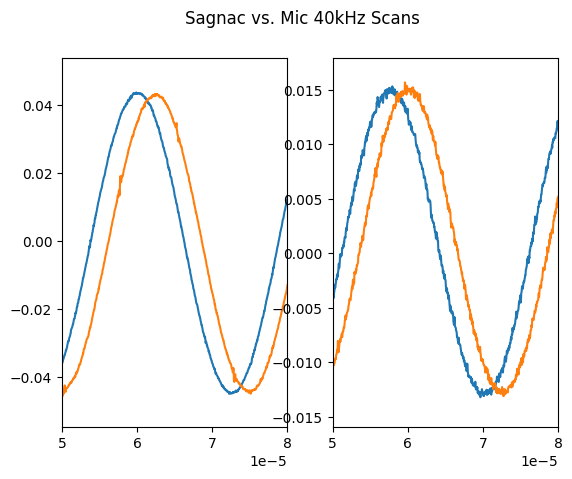

In [11]:
import matplotlib.pyplot as plt

sag_dat, mic_dat = sagnac_40kHz.get_data()[1], mic_40kHz.get_data()[1]
fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0.00005, 0.00008])
ax[1].set_xlim([0.00005, 0.00008])
fig.suptitle("Sagnac vs. Mic 40kHz Scans")
for sag_shot, mic_shot in zip(sag_dat.collection, mic_dat.collection):
    ax[0].plot(sag_shot.t, sag_shot.x)
    ax[1].plot(mic_shot.t, mic_shot.x)
        

---
# Ablation Energy Scans (20 shots)
### Starting energy = 11J
### Ending energy = 13J
##### Phi = 19

Data loaded into System class:

In [12]:
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 1e6)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 2e5)

Here I take the Daici correction function and apply it to the Sagnac data using apply("correct"). I have some issues with this strategy. Firstly, I'm unsure of the transfer function, so I'll be checking it against the impulse response later in the data analysis. I also have disabled the mic_correct on the microphone channel. This correction has been found to be inaccurate, and it adds a "ghosting" or pre-ringing/pre-echo to the mic signal. This is unacceptable. I'll be investigating how to correct this.

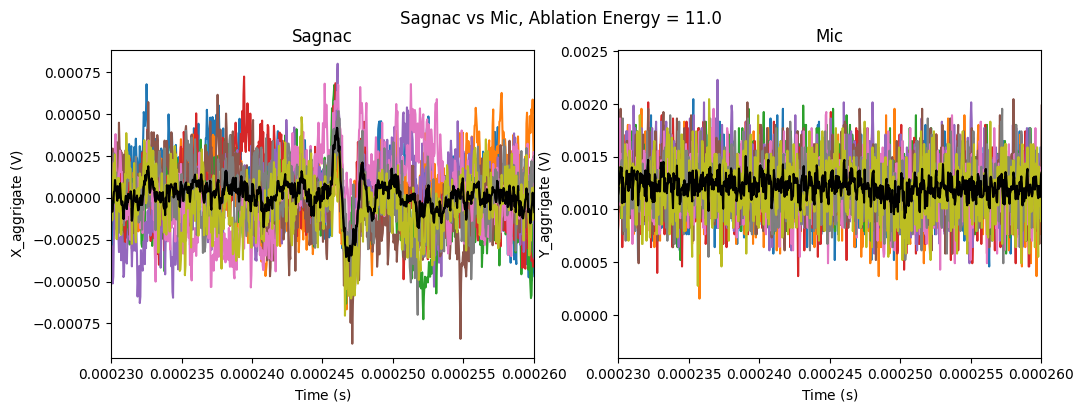

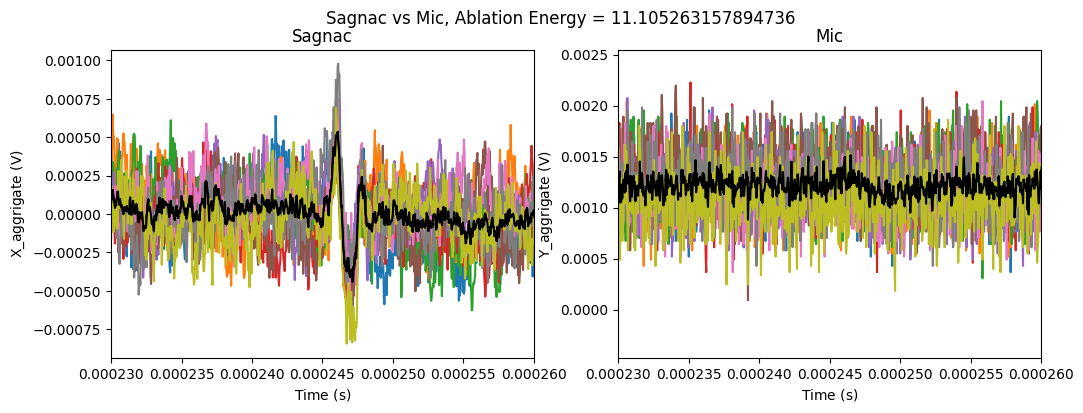

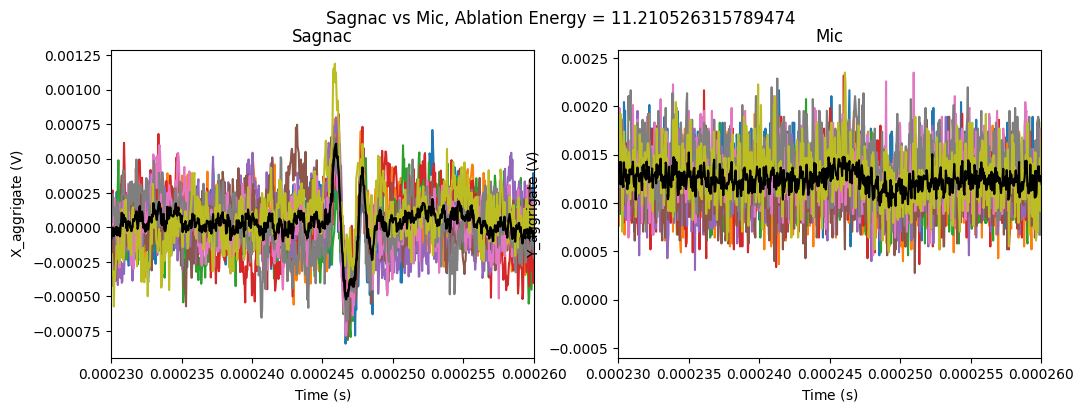

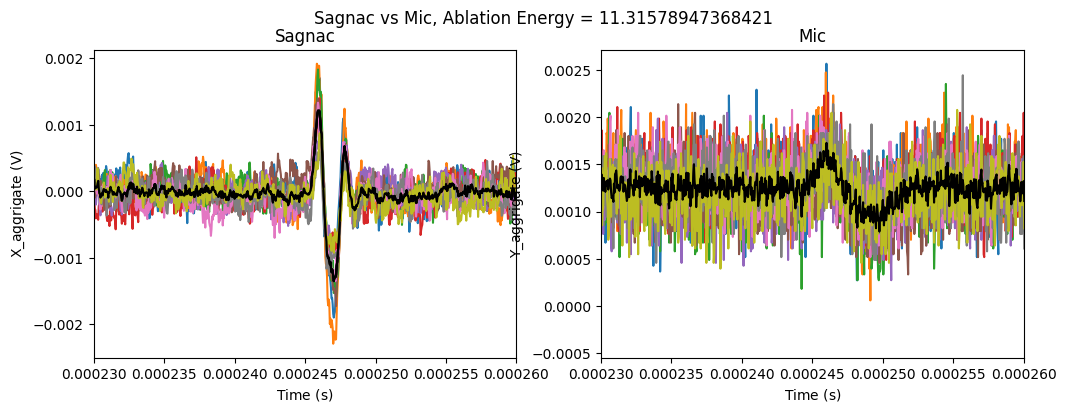

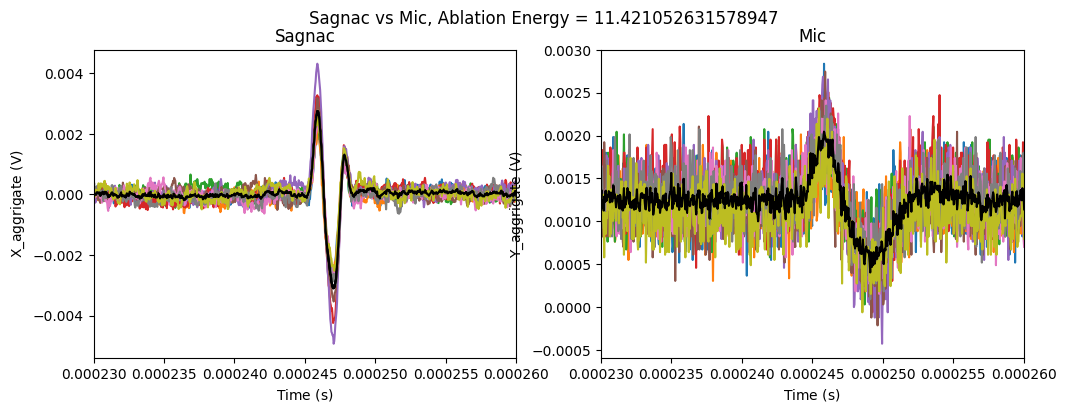

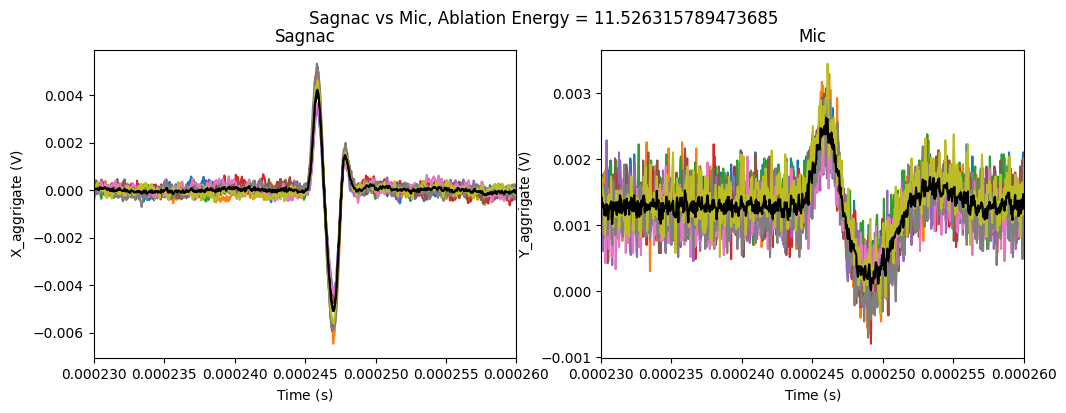

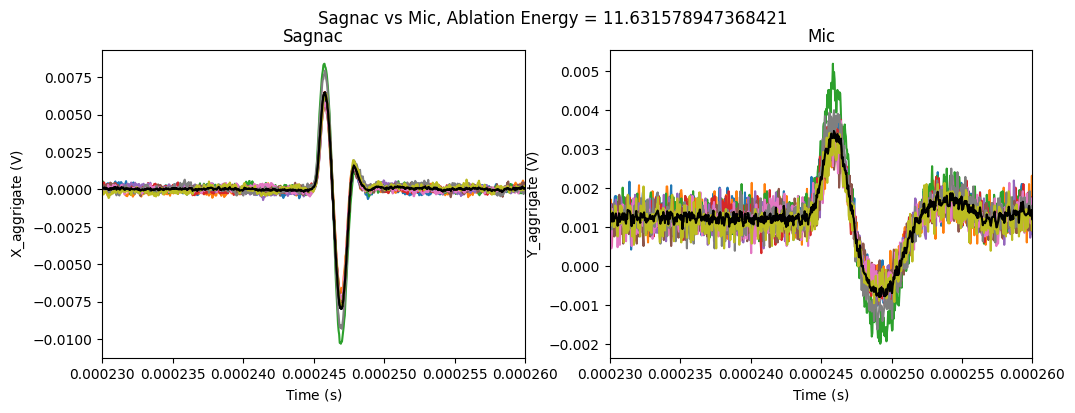

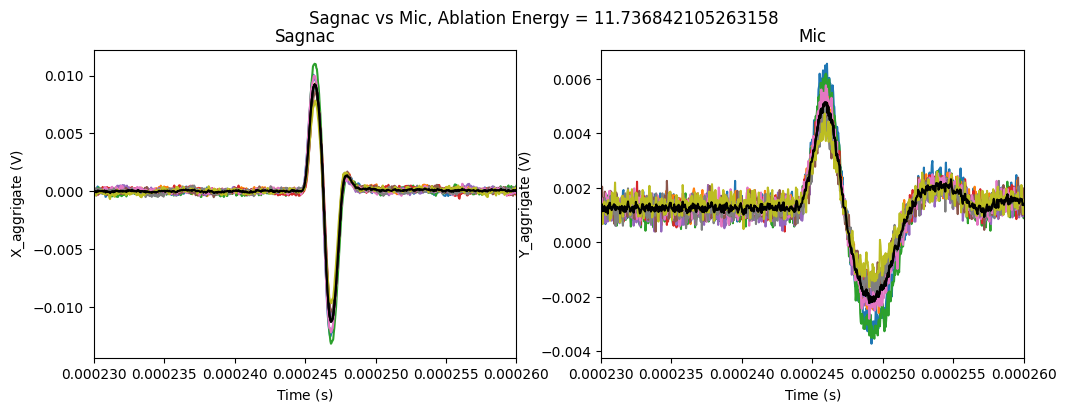

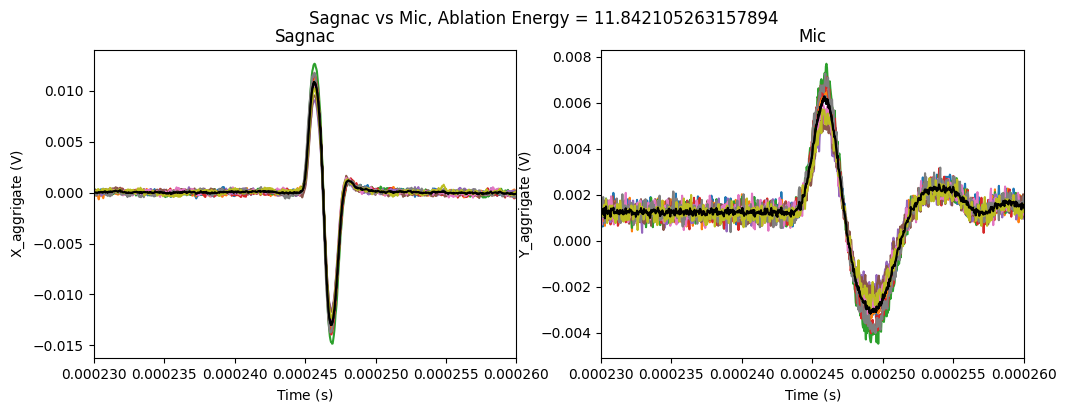

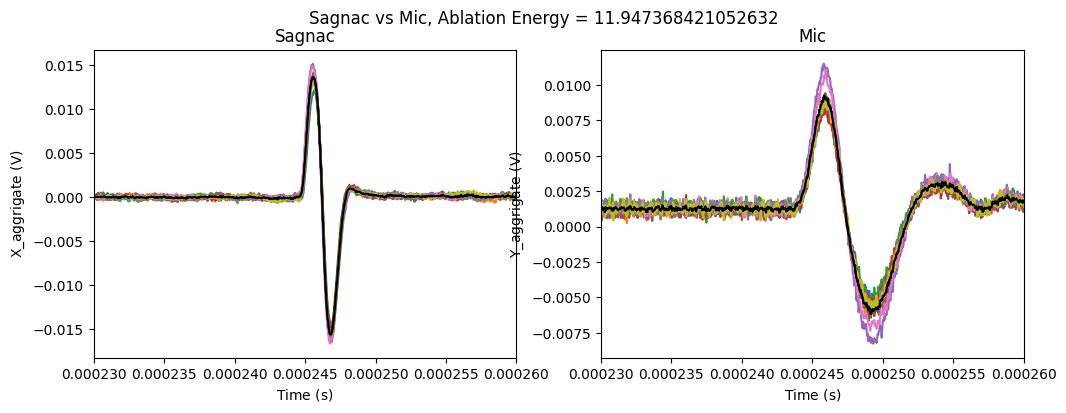

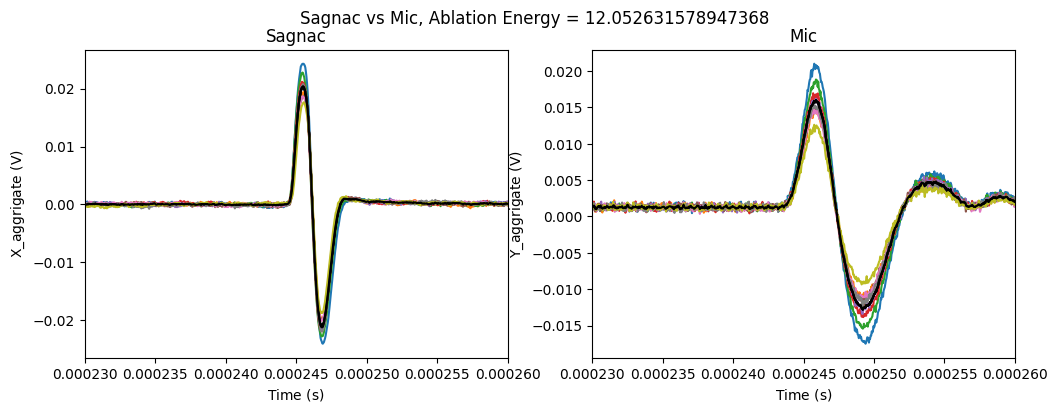

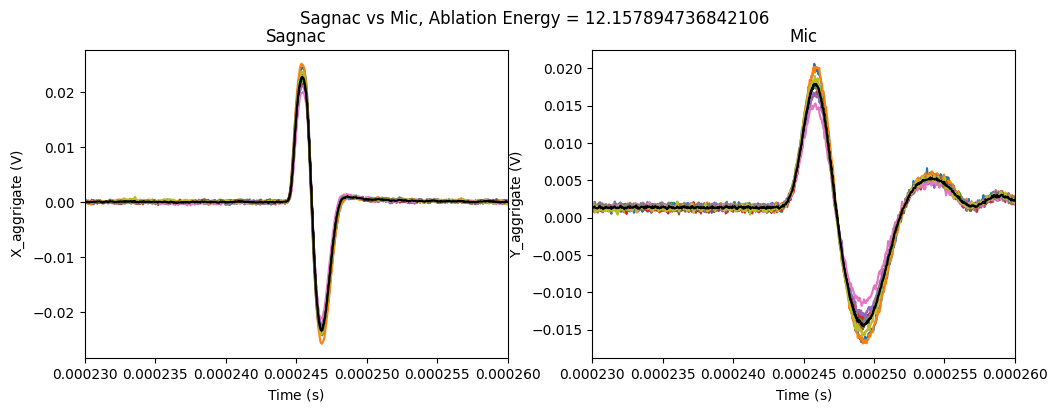

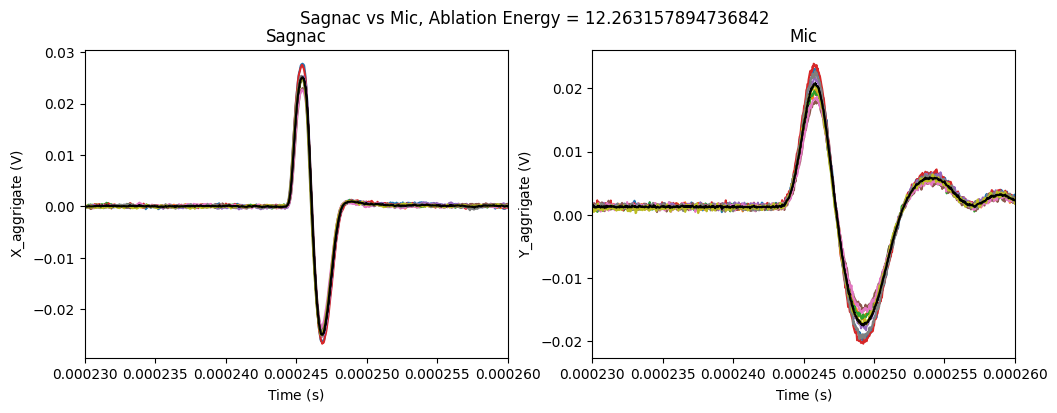

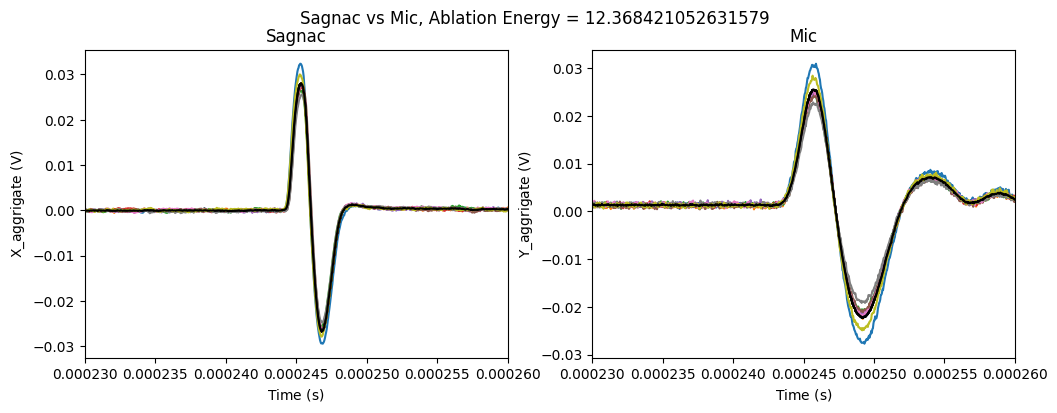

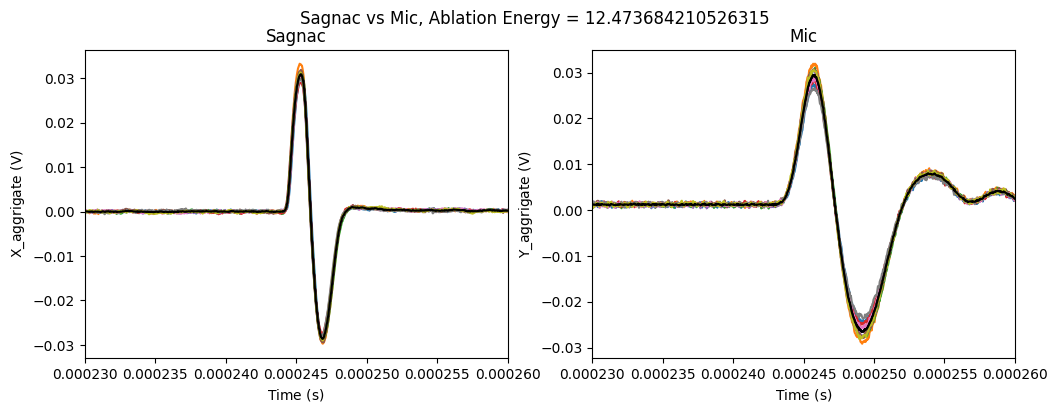

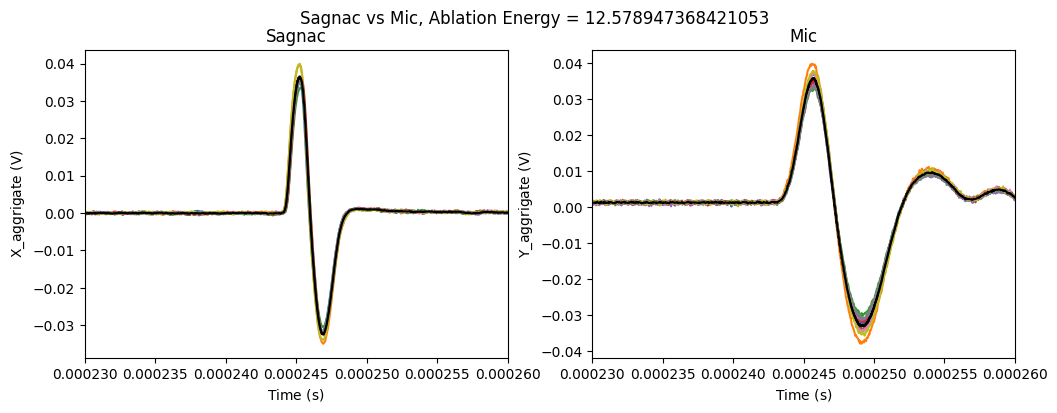

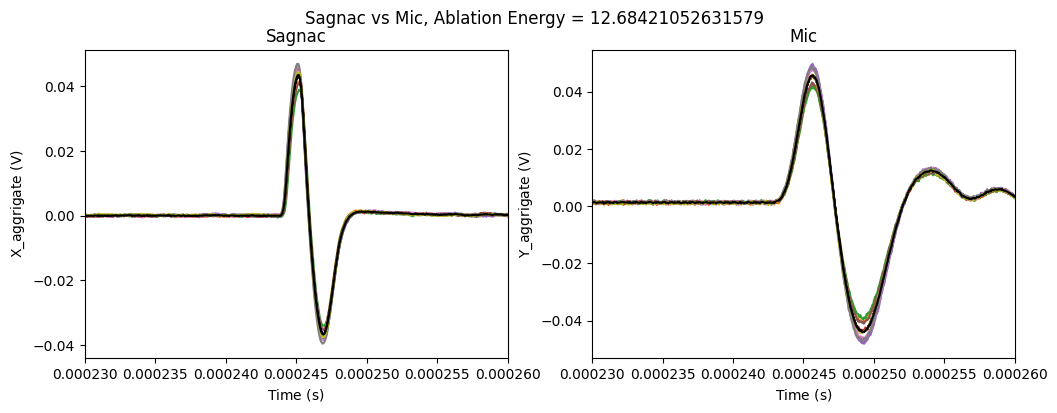

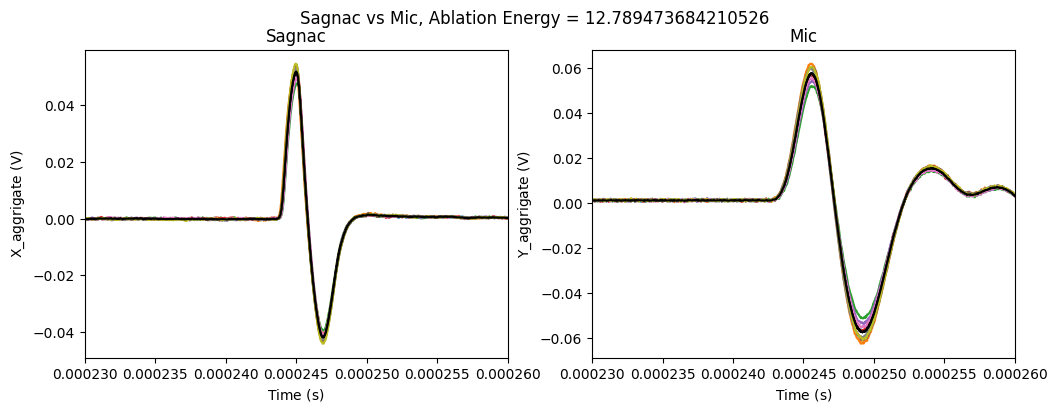

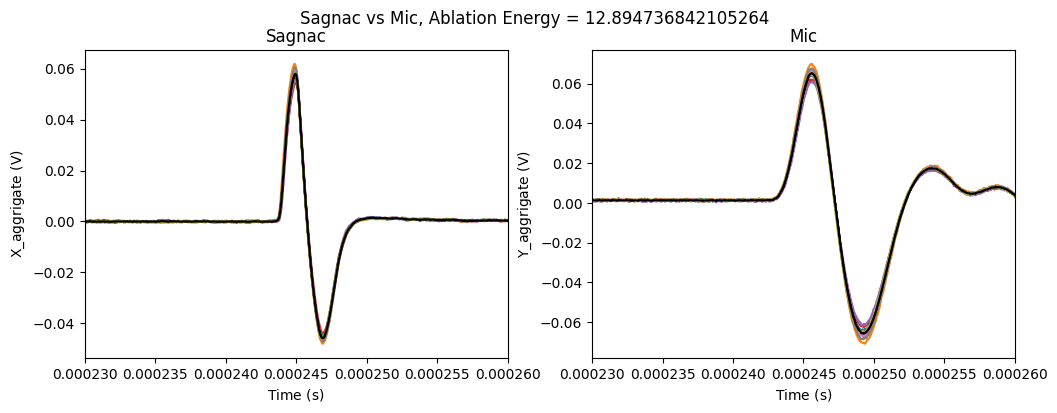

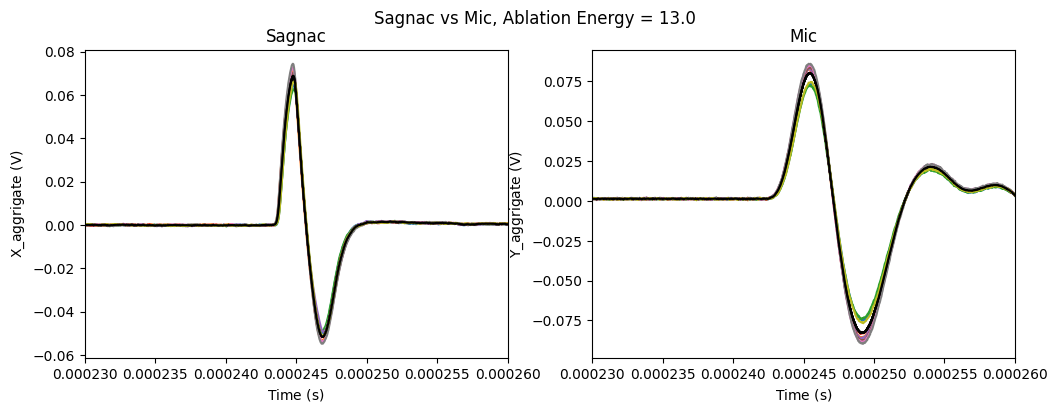

In [13]:
import matplotlib.pyplot as plt

def Daici(freq, dist = 0.033, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

for i, (s_dat, m_dat) in enumerate(zip(sagnac_ene_scan.get_data(), mic_ene_scan.get_data())):
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]
    
    s_dat.apply("correct", tmin = 0.00022, tmax = 0.00027, response = Daici, recollect = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    ax[0].set_title("Sagnac")
    ax[0].set_xlim([0.00023, 0.00026])
    ax[1].set_title("Mic")
    ax[1].set_xlim([0.00023, 0.00026])
    fig.suptitle("Sagnac vs Mic, Ablation Energy = " + str(s_dat.ene))
    for s_shot, m_shot in zip(s_dat.collection[2:], m_dat.collection[2:]):
        s_dat.aggrigate(collection_slice = slice(2, len(s_dat.collection), 1))
        ax[0].plot(s_shot.t, s_shot.x)
        s_dat.agg.plot(ax = ax[0], c = "k")
        m_dat.aggrigate(collection_slice = slice(2, len(m_dat.collection), 1))
        ax[1].plot(m_shot.t, m_shot.x)
        m_dat.agg.plot(ax = ax[1], c = "k")
    
    mic_ene_scan.set_data(ind = i, mic_correct = False)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]

---
# Digital Filtering

I first begin by importing the newest data set. Energy scans taken on Jan. 5th from 11J to 12J with 20 shots at a $\phi = $ 154$\degree$. 

In [14]:
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR = False)

I've started by importing some important packages. I then defined a new `mic_correct` function that takes advatage of the `scipy.signal` package. This function creates a digital filter and applies it to the microphone signal. I then compare this signal processing to the raw signal and the old `mic_correct` function (that has known errors, i.e. ringing).

I first defined our new `mic_correct` function. This function creates a digital filter using `sig.firwin2`. It then converts this filter to a minimum phase signal (we found this to be the most applicable to our needs) using `sig.minimum_phase`. This minimum phase filter is then FFT'd and iFFT'd while only keeping the real values. The filter is applied to our signal using `sig.filtfilt`.

The results are compared below.

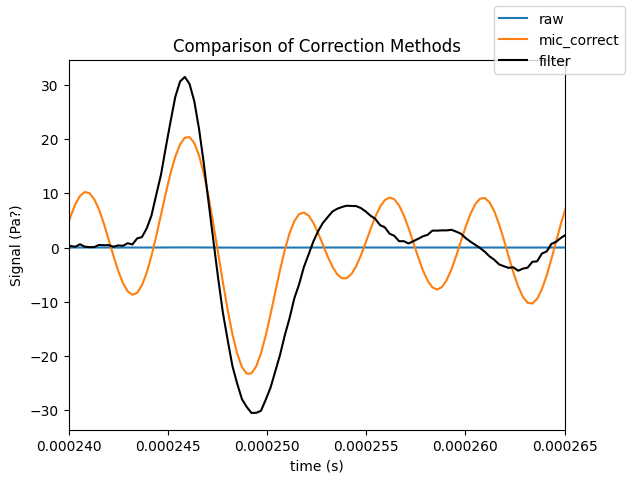

In [15]:
import acoustic_entrainment
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

i = 10
col_ind = 2

def mic_correct(c, taps = 3, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

mic_ene_scan.set_data(ind = i)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
t, x = m_dat.collection[col_ind].t, m_dat.collection[col_ind].x
ax.plot(t, x, label = "raw")

mic_ene_scan.set_data(ind = i, mic_correct = True)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
t, x = m_dat.collection[col_ind].t, m_dat.collection[col_ind].x
ax.plot(t, x, label = "mic_correct")

mic_ene_scan.set_data(ind = i)
m_dat = mic_ene_scan.get_data()[i]
m_dat.apply("detrend", mode = "constant", inplace = True)
m_dat.collection[col_ind].t, m_dat.collection[col_ind].x = mic_correct(m_dat.collection[col_ind], 151)
m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
t, x = m_dat.collection[col_ind].t, m_dat.collection[col_ind].x
ax.plot(t, x, label = "filter", color = "k")

fig.legend()
ax.set_title("Comparison of Correction Methods")
ax.set_xlabel("time (s)")
ax.set_ylabel("Signal (Pa?)")
ax.set_xlim([2.4e-4, 2.65e-4])
plt.show()

# data converges with Logan's

It can be seen in the plot above that our digital filter microphone correction works quite well! I'm happy with these results, and I'll now move on to some additional data processing below.
***

In [16]:
from analysis import System

sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 1e6)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 2e5)

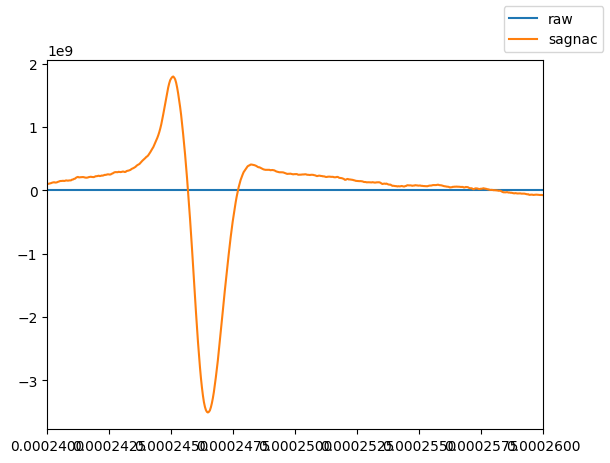

In [17]:
### import acoustic_entrainment
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
# ax.set_xlim([0.00035, 0.00039])

def Daici(freq, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)
    
def laser_impulse(t, dist = 0.09, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    a = get_sound_speed(T, 0.5, 99e3)
    tau = dist / a
    return (tau ** 2) / np.power((t * (t + (2 * tau))), (3/2))

sagnac_ene_scan.set_data(ind = i)
s_dat = sagnac_ene_scan.get_data()[i]
freq = np.linspace(1, 2e6, 1000)
gains = Daici(freq)
filter = np.real(np.fft.fft(1 / np.fft.ifft(sig.firwin2(len(gains) - 1, np.r_[0, freq], np.r_[0, gains], fs = 2 * freq[-1]))))
s_dat.apply("detrend", mode = "constant", inplace = True)
t0, x0 = s_dat.collection[8].t, s_dat.collection[8].x
# x0 /= max(x0)
ax.plot(t0, x0, label = "raw")
t, x = s_dat.collection[8].t, sig.filtfilt(filter, [1], s_dat.collection[8].x)
# x /= max(x)
ax.plot(t, x, label = "sagnac")

ax.set_xlim([2.4e-4, 2.6e-4])
fig.legend()

***
# Final Plots

In this first block, I import some necessary packages. I also initiate two `System` objects that'll hold the data we'll be using for some of our plots. I've also set default values for the styles we'll be using for fonts and labels in our plots.

In [138]:
from analysis import System
import matplotlib as mpl

sagnac_ene_scan = System("sagnac", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 1e6)
mic_ene_scan = System("mic", ["../data/20240104/ablation-ene-scan-11-13-20_phi-19_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(20)], SNR_freq_cut = 2e5)

fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.latex.preamble":
        r'\usepackage{upgreek}',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)

letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()]
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):    
    letters = letters_map[mode]    
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,            
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

## Raw Minimum Detectable Signal

In this section, I've used the impulse response function of the microphone to create a function that corrects our signal using a digital filter. 

I've also implemented a (somewhat questionable?) laser correction function using the Daici transfer function. We may or may not use this in our final plots. At the end of this cell, I've created the first plot that we'll be using for our paper

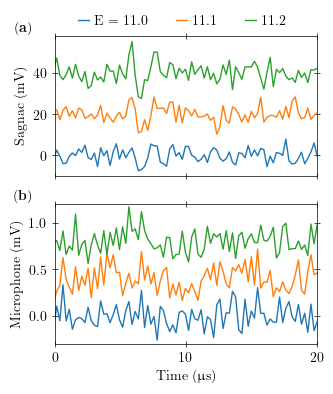

In [160]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, sharex = True)

for i in range(len(sagnac_ene_scan.get_data()) - 17):
    col_ind = 3
    mic_ene_scan.set_data(ind = i)
    m_dat = mic_ene_scan.get_data()[i]
    sagnac_ene_scan.set_data(ind = i)
    s_dat = sagnac_ene_scan.get_data()[i]
    
    s_dat.apply("bin_average", Npts = int(s_dat.r / (2e6 * 2)), inplace = True)
    s_dat.apply("detrend", mode = "constant", inplace = True)
    sagnac_ene_scan.local_detrend(tmin = 2.4e-4, tmax = 2.6e-4, index = i, inplace = True)
    t, x = (s_dat.collection[col_ind].t - 2.4e-4) * 1e6, (s_dat.collection[col_ind].x + (i * 0.02)) * 1e3
    if i == 0:
        label = f"E = {s_dat.ene:.1f}"
    else:
        label = f"{s_dat.ene:.1f}"
    ax[0].plot(t, x, label = label, lw = 1)
    m_dat.apply("bin_average", Npts = int(m_dat.r / (2e6 * 2)), inplace = True)
    m_dat.apply("detrend", mode = "constant", inplace = True)
    mic_ene_scan.local_detrend(tmin = 2.4e-4, tmax = 2.6e-4, index = i, inplace = True)
    t, x = (m_dat.collection[col_ind].t - 2.4e-4) * 1e6, (m_dat.collection[col_ind].x + (i * 0.0004)) * 1e3
    ax[1].plot(t, x, lw = 1)

ax[0].set_xlim([0, 20])
ax[0].set_ylim([-10, 58])
ax[0].set_ylabel("Sagnac (mV)")
ax[0].tick_params(direction = "inout", length = 5)
lettering(ax[0], -0.12, 1.05, 0)

ax[1].set_xlim([0, 20])
ax[1].set_ylim([-0.3, 1.2])
ax[1].set_xlabel(r"Time ($\upmu$s)")
ax[1].set_ylabel("Microphone (mV)")
ax[1].tick_params(direction = "inout", length = 5)
lettering(ax[1], -0.12, 1.05, 1)

fig.set_size_inches(3.375, 4)
fig.legend(loc = "lower center", frameon = False, ncol = 3, bbox_to_anchor = (0.50, 0.87), handlelength = 0.8, handletextpad = 0.4)
ax[0].locator_params(axis='x', nbins=3)
ax[1].locator_params(axis='x', nbins=3)
fig.savefig("minimum_detectable.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

## PSD of Multiple Systems & Trough Matching

I first begin by importing necessary packages. I then initialize `systems` which holds all of the four systems that we compared for detecting sound signals of laser ablations. The SNRs of these systems are then each calculated.

In [162]:
import analysis
import numpy as np
import matplotlib.pyplot as plt
# ("telescope", "Telescope"), 
cutoff = 1e6
names = [("microphone", "Sagnac"), ("sagnac", "Sagnac"), ("split beam", "SplitBeam")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, analysis.System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], phis = [int(p[3:-5]) for p in phis]))

def Daici(freq, dist = 0.1, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def mic_correct(c, taps = 151, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

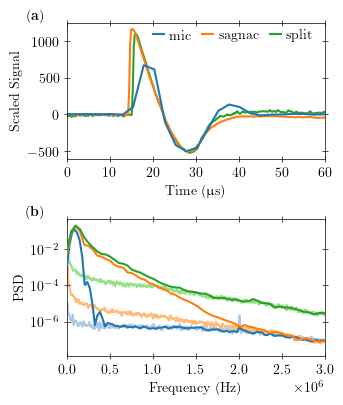

In [196]:
fig, ax = plt.subplots(2, 1)
cmap = plt.colormaps['tab20']

ind = 0
col_i = 1
laser_cutoff = 2e6
mic_cutoff = 2e5
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

cals = []
tau = []
for i, s in enumerate(systems):
    s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
    if s.get_name()[:3] != "mic":
        s.local_detrend([], ind, 3.5e-4, 4.05e-4, True)
        s.get_data()[ind].apply("correct", response = Daici, recollect = True)
        s.get_data()[ind].apply("lowpass", cutoff = laser_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(s.get_data()[ind].r / (2 * laser_cutoff)), inplace = True)
        cals.append(analysis.calc_calibration_factors(s, systems[0], ind))
        tau.append(analysis.mic_tau_shift(s, systems[0], ind, col_i))
        s.get_data()[ind].apply("calibrate", cal = cals[i - 1][col_i - 1], inplace = True)
        s.get_data()[ind].apply("shift", tau = -tau[i - 1], inplace = True)
    else:
        s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
        s.get_data()[ind].apply("lowpass", cutoff = mic_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(s.get_data()[ind].r / (2 * mic_cutoff)), inplace = True)
    ax[0].plot(s.get_data()[ind].collection[col_i].t * 1e6 - 400, s.get_data()[ind].collection[col_i].x, zorder = 2 - i)
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

# concluding figure (a)

names = ["mic", "sagnac", "split"]

for i, s in enumerate(systems):
    ind = 2
    laser_cutoff = 3e6
    mic_cutoff = 3e6
    
    s.set_data(ind = ind)
    
    d = s.get_data()[ind]
    d.apply("detrend", mode = "constant", inplace = True)
    if s.get_name()[:3] == "mic":
        for col in d.collection:
            col.t, col.x = analysis.mic_correct(col)
        d.apply("lowpass", cutoff = mic_cutoff, inplace = True)
        d.apply("bin_average", Npts = int(d.r / (2 * mic_cutoff)), inplace = True)
        freq_signal, psd_signal = d.average("PSD", tmin = 4.14e-4, tmax = 4.48e-4)
    else:
        s.local_detrend([], ind, 0, 4.2e-4, True)
        d.apply("correct", response = Daici, recollect = True)
        d.apply("lowpass", cutoff = laser_cutoff, inplace = True)
        d.apply("bin_average", Npts = int(d.r / (2 * laser_cutoff)), inplace = True)
        calibration_factors = analysis.calc_calibration_factors(s, systems[0], ind)
        d.apply("calibrate", cal = np.mean(calibration_factors), inplace = True)
        freq_signal, psd_signal = d.average("PSD", tmin = 4.37e-4, tmax = 4.57e-4)
    freq_noise, psd_noise = d.average("PSD", tmin = 1.5e-4, tmax = 3.5e-4)
    ax[1].plot(freq_noise, psd_noise, c = cmap.colors[2 * i + 1], zorder = i)
    ax[1].plot(freq_signal, psd_signal, label = names[i], c = cmap.colors[2 * i], zorder = i + 3)

ax[0].set_xlim(0, 6e1)
ax[0].set_xlabel(r"Time ($\upmu$s)")
ax[0].set_ylabel("Scaled Signal")
lettering(ax[0], -0.12, 1.05, 0)

ax[1].set_yscale("log")
ax[1].set_xlim([0, 3e6])
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("PSD")
lettering(ax[1], -0.12, 1.05, 1)
fig.set_size_inches(3.375, 4)
fig.tight_layout(pad = 0.5)
fig.legend(loc = "lower center", frameon = False, ncol = 3, bbox_to_anchor = (0.68, 0.87), handlelength = 0.8, handletextpad = 0.4, columnspacing = 0.8)
fig.savefig("PSD_and_trough_matching.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

## SNR vs P$_{out}$

In this section, the results of SNR vs P$_{out}$ measurements are compiled. We can show that the SNR of our Sagnac detector outperforms the single photodiode detector at almost all P$_{out}$'s. At some lower values for the power, it even outperforms the microphone.

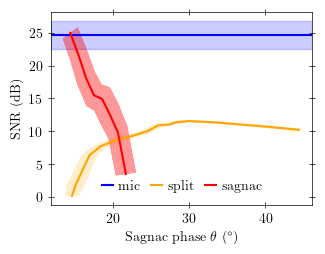

In [210]:
from scipy.stats import binned_statistic
def sagnac_phase(Pout, Pin):
    import numpy as np
    return 2 * np.arcsin(np.sqrt(np.array(Pout) / Pin))
def err_sagnac_phase(err, Pin):
    import numpy as np
    return np.abs((1 / (Pin * np.sqrt((err * (Pin - err)) / np.power(Pin, 2)))) * err)   

CCW_Pin = 100.8 #mW
err_CCW_Pin = 0.3 #mW
CW_Pin = 110.4 #mW
err_CW_Pin = 0.72 #mW
single_Pin = 108.2 #mW
err_single_Pin = 0.55 #mW
Pin = 122.75 #mW, for split_runs and single_runs[0]
err_Pin = 0.81 #mW

SNR_mic = 24.7
err_SNR_mic = 2.1

CCW_runs = [[[23.8], 
             [1.74]], 
            [[19.1, 21.8, 24.2, 24.5], 
             [2.12, 1.98, 1.86, 1.79]], 
            [[14.5, 15.6, 17.5, 17.5, 20.1, 22.8], 
             [2.30, 2.20, 2.13, 1.94, 1.86, 1.73]]]
err_CCW_runs = [[[2.1], 
                 [0.04]], 
                [[2.2, 1.9, 1.4, 1.6], 
                 [0.04, 0.04, 0.04, 0.04]], 
                [[1.2, 1.7, 1.5, 1.0, 1.7, 1.5], 
                 [0.04, 0.05, 0.05, 0.03, 0.03, 0.04]]]
CW_runs = [[[24.1], 
            [1.37]], 
           [[13.5, 14.2, 14.8, 16.2, 18.3, 19.2, 22.9, 24.1], 
            [2.74, 2.60, 2.51, 2.35, 2.23, 2.12, 2.00, 1.98]], 
           [[4.3, 2.7, 5.9, 6.8, 11.2, 13.1, 13.7, 14.3, 16.1, 17.1, 17.8, 20.0, 24.6, 25.2], 
            [4.30, 4.05, 3.68, 3.53, 3.27, 3.09, 2.98, 2.85, 2.73, 2.55, 2.48, 2.25, 2.13, 2.09]]]
err_CW_runs = [[[2.1], 
                [0.03]], 
               [[2.3, 2.2, 2.6, 2.8, 2.6, 2.1, 2.3, 2.1], 
                [0.03, 0.05, 0.04, 0.04, 0.04, 0.03, 0.02, 0.03]], 
               [[1.2, 1.1, 1.6, 1.7, 1.8, 2.1, 2.1, 1.9, 1.8, 2.3, 2.0, 2.3, 1.8, 1.8], 
                [0.06, 0.06, 0.05, 0.04, 0.05, 0.05, 0.06, 0.06, 0.05, 0.06, 0.06, 0.04, 0.04, 0.06]]]
single_runs = [[[0.32, 1.82, 2.15, 2.55, 2.86, 3.44, 4.12, 4.15, 4.48, 4.35, 5.74, 4.95, 6.17, 6.46, 6.10, 5.42, 4.94, 4.05, 3.38], 
               [59.53, 58.42, 58.49, 57.70, 55.91, 55.65, 54.37, 51.47, 48.41, 46.62, 40.28, 38.51, 32.11, 27.81, 20.32, 15.56, 13.48, 10.54, 8.29]],
               [[10.22, 10.61, 11.07, 11.36, 11.56, 11.43, 11.34, 11.06, 10.90, 10.02, 9.32, 8.78, 7.70, 6.35, 1.90, 0.18], 
               [17.51, 15.05, 11.95, 10.04, 8.17, 7.58, 7.25, 6.95, 6.18, 5.56, 4.73, 3.94, 3.14, 2.67, 2.14, 2.00]]]
single_runs = [single_runs[1]]
err_single_runs = [[[0.09, 0.12, 0.10, 0.09, 0.13, 0.28, 0.11, 0.41, 0.09, 0.12, 0.09, 0.12, 0.10, 0.08, 0.09, 0.07, 0.07, 0.11, 0.09], 
                   [0.24, 0.32, 0.29, 0.20, 0.27, 0.22, 0.22, 0.30, 0.25, 0.20, 0.17, 0.16, 0.17, 0.12, 0.13, 0.13, 0.11, 0.07, 0.11]],
                  [[0.17, 0.21, 0.15, 0.14, 0.17, 0.20, 0.19, 0.17, 0.22, 0.21, 0.22, 0.26, 0.27, 0.28, 0.26, 0.07], 
                   [0.11, 0.13, 0.10, 0.08, 0.05, 0.06, 0.07, 0.05, 0.06, 0.05, 0.05, 0.04, 0.05, 0.04, 0.05, 0.03]]]
err_single_runs = [err_single_runs[1]]
split_runs = [[[26.52], 
               [1.94]], 
              # set P_det to ~800 microWatts, then back to 1 milliWatts (spun towards me)
              [[20.82, 21.64, 28.40], 
               [2.61, 2.56, 2.22]], 
              # set P_det to ~500 microWattts, then back to 1 milliWatts (spun towards me)
              [[13.74, 15.21, 16.82, 18.00, 19.21, 20.15, 21.44, 23.02, 25.12, 27.11],
               [4.07, 3.91, 3.82, 3.46, 3.08, 2.77, 2.60, 2.42, 2.27, 1.94]]]
err_split_runs = [[[1.72], 
                   [0.08]], 
                  [[1.64, 2.12, 1.81], 
                   [0.03, 0.08, 0.05]], 
                  [[2.32, 2.05, 2.11, 2.35, 2.04, 1.84, 1.82, 1.95, 2.03, 1.49],
                   [0.06, 0.06, 0.06, 0.05, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04]]]

fig, ax = plt.subplots(1, 1, figsize = (3.375, 2.5))

Pins = [CCW_Pin, CW_Pin, single_Pin, Pin]
data = [CCW_runs, CW_runs, single_runs, split_runs]
err_data = [err_CCW_runs, err_CW_runs, err_single_runs, err_split_runs]
Pouts = np.array([])
SNRs = np.array([])
err_Pouts = np.array([])
err_SNRs = np.array([])
for i, dat in enumerate(data):
    for j, d in enumerate(dat):
        for k, s in enumerate(d[1]):
            if i != 2 and j != 0:
                d[1][k] = sagnac_phase(s, Pins[i])
                err_data[i][j][1][k] = err_sagnac_phase(err_data[i][j][1][k], Pins[i])
                if i != 2:
                    SNRs = np.append(SNRs, d[0][k])
                    err_SNRs = np.append(err_SNRs, err_data[i][j][0][k])
                    Pouts = np.append(Pouts, d[1][k])
                    err_Pouts = np.append(err_Pouts, err_data[i][j][1][k])
            else: 
                d[1][k] = sagnac_phase(s, Pins[3])
                err_data[i][j][1][k] = err_sagnac_phase(err_data[i][j][1][k], Pins[2])

c = binned_statistic(Pouts, SNRs, statistic = "mean", bins = 8)
s = binned_statistic(Pouts, SNRs, statistic = "std", bins = 8)
d = binned_statistic(Pouts, err_Pouts, statistic = "mean", bins = 8)
err_SNRs = binned_statistic(Pouts, err_SNRs, statistic = "mean", bins = 8)

def draw_error_band(ax, x, y, xerr, yerr, **kwargs):
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l
    xp = x + nx * xerr
    yp = y + ny * yerr
    xn = x - nx * xerr
    yn = y - ny * yerr
    vertices = np.block([[xp, xn[::-1]], [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

ax.set_xlabel(r"Sagnac phase $\theta$ ($^\circ$)") # change this
ax.set_ylabel("SNR (dB)")
ax.axhline(SNR_mic, 0, 1, label = "mic", color = "b")
ax.axhspan(SNR_mic - err_SNR_mic, SNR_mic + err_SNR_mic, 0, 1, alpha = 0.2, color = "b")
ax.plot(np.array(data[2][0][1]) * (180 / np.pi), data[2][0][0], label = "split", color = "orange")
draw_error_band(ax, x = np.r_[np.array(data[2][0][1]) * (180 / np.pi), (np.array(data[2][0][1]) * (180 / np.pi))[::-1]], y = np.r_[data[2][0][0], (data[2][0][0])[::-1]], xerr = np.r_[np.array(err_data[2][0][1]) * (180 / np.pi), (np.array(err_data[2][0][1]) * (180 / np.pi))[::-1]], yerr = np.r_[np.array(err_data[2][0][0]), np.array(err_data[2][0][0])[::-1]], alpha = 0.2, facecolor = "orange", edgecolor = "none")
ax.plot(c.bin_edges[:-1] * (180 / np.pi), c.statistic, label = "sagnac", color = "red")
draw_error_band(ax = ax, x = np.r_[c.bin_edges[:-1] * (180 / np.pi), (c.bin_edges[:-1] * (180 / np.pi))[::-1]], y = np.r_[c.statistic, c.statistic[::-1]], xerr = np.r_[d.statistic * (180 / np.pi), (d.statistic * (180 / np.pi))[::-1]], yerr = np.r_[np.sqrt(np.power(s.statistic, 2) + np.power(err_SNRs.statistic, 2)), (np.sqrt(np.power(s.statistic, 2) + np.power(err_SNRs.statistic, 2)))[::-1]], facecolor = "red", alpha = 0.4, edgecolor = "none")
ax.legend(loc = "lower center", frameon = False, ncol = 3, bbox_to_anchor = (0.5, 0), handlelength = 0.8, handletextpad = 0.4, columnspacing = 0.8)

fig.savefig("SNR_vs_phase.pdf", format = "pdf", bbox_inches = "tight")
plt.show()

## 40 kHz Comparisons

This graph shows a signal created with a piezo accoustic device emitting sound at a constant 40kHz. Measurements were taken with the sagnac and microphone systems alike.

In [25]:
from analysis import System
import numpy as np
import matplotlib.pyplot as plt

sagnac_40kHz = System("sagnac", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)])
mic_40kHz = System("mic", ["../data/20240104/40KHz_sagnac_mic/iter_" + str(n) + ".tdms" for n in range(3)])

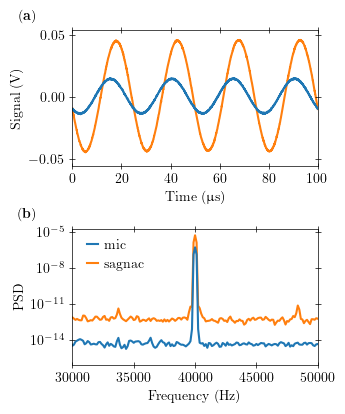

In [241]:
ind = 0

sagnac_40kHz.set_data(ind = ind)
mic_40kHz.set_data(ind = ind)
s = sagnac_40kHz.get_data()[ind]
m = mic_40kHz.get_data()[ind]

col_i = 0
fig, ax = plt.subplots(2, 1, figsize = (3.375, 4))

ax[0].plot(m.collection[col_i].t * 1e6, m.collection[col_i].x, label = "mic", zorder = 1)
ax[0].plot(s.collection[col_i].t * 1e6, s.collection[col_i].x, label = "sagnac", zorder = 0)

s_freq, s_psd = s.average("PSD", taumax = 8e-3)
m_freq, m_psd = m.average("PSD", taumax = 8e-3)
ax[1].plot(m_freq, m_psd, zorder = 1)
ax[1].plot(s_freq, s_psd, zorder = 0)
l_SNR = np.sum(s_psd[310:331]) /  (np.sum(s_psd[:310]) + np.sum(s_psd[331:630]) + np.sum(s_psd[651:950]) + np.sum(s_psd[971:]))
m_SNR = np.sum(m_psd[310:331]) / (np.sum(m_psd[:310]) + np.sum(m_psd[331:630]) + np.sum(m_psd[651:950]) + np.sum(m_psd[971:]))

ax[0].set_xlim([0, 1e2])
ax[0].set_ylabel("Signal (V)")
ax[0].set_xlabel(r"Time ($\upmu$s)")
lettering(ax[0], -0.18, 1.1, 0)

ax[1].set_xlim([3e4, 5e4])
ax[1].set_ylabel("PSD")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_yscale("log")
lettering(ax[1], -0.18, 1.1, 1)
fig.tight_layout(pad = 0.2)
fig.legend(loc = "center left", frameon = False, bbox_to_anchor = (0.22, 0.38), handlelength = 0.8, handletextpad = 0.4, columnspacing = 0.6)
fig.savefig("40kHz_signal_comparison.pdf", format = "pdf", bbox_inches = "tight")
plt.show()